## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from pandas_profiling import ProfileReport

## Preprocessing the datasets

### Training Dataset

In [2]:
# train_path = '../input/data-storm-30/train_data.csv'
train_path = 'train_data.csv'
train_dataset = pd.read_csv(train_path)
train_dataset = train_dataset.drop_duplicates(keep = 'first')

In [3]:
print(train_dataset.columns)
print('No. of different categories: {}'.format(len(train_dataset['CategoryCode'].unique())))
print('No. of different items: {}'.format(len(train_dataset['ItemCode'].unique())))


Index(['CategoryCode', 'ItemCode', 'DateID', 'DailySales'], dtype='object')
No. of different categories: 4
No. of different items: 194


In [4]:
# converting the dtype of the DateID
train_dataset['DateID'] = pd.to_datetime(train_dataset['DateID'])
train_dataset.sort_values(by = 'DateID', inplace=True)
print(train_dataset.dtypes)

CategoryCode            object
ItemCode                 int64
DateID          datetime64[ns]
DailySales               int64
dtype: object


In [5]:
train_dataset.head()
# train_dataset

,CategoryCode,ItemCode,DateID,DailySales
8710,category_2,174436,2021-10-01,9
8809,category_2,118033,2021-10-01,4
19919,category_2,20824,2021-10-01,7
8802,category_1,1061341,2021-10-01,11
8801,category_1,76399,2021-10-01,14


In [6]:
flag = 0
for item in train_dataset['ItemCode'].unique():
    tmp_dataset = train_dataset.loc[train_dataset['ItemCode'] == item]
    if len(tmp_dataset['CategoryCode'].unique()) == 1:
        continue
    else:
        print('CategoryCode for an ItemCode is not unique')
        flag = 1
        break

### Validation Dataset

In [7]:
valid_path = 'validation_data.csv'
validation_dataset = pd.read_csv(valid_path)
validation_dataset = validation_dataset.drop_duplicates(keep = 'first')

In [8]:
print(validation_dataset.columns)
print('No. of different categories: {}'.format(len(validation_dataset['CategoryCode'].unique())))
print('No. of different items: {}'.format(len(validation_dataset['ItemCode'].unique())))

Index(['CategoryCode', 'ItemCode', 'Week', 'WeeklySales'], dtype='object')
No. of different categories: 4
No. of different items: 95


### Test Dataset

In [9]:
test_path = 'test_data.csv'
test_dataset = pd.read_csv(test_path)
test_dataset = test_dataset.drop_duplicates(keep = 'first')

In [10]:
print(test_dataset.columns)
print('No. of different categories: {}'.format(len(test_dataset['CategoryCode'].unique())))
print('No. of different items: {}'.format(len(test_dataset['ItemCode'].unique())))

Index(['CategoryCode', 'ItemCode', 'Week', 'PredictedSales'], dtype='object')
No. of different categories: 4
No. of different items: 97


## Defining the model


### Picking an item

In [11]:
item_num = 174436
tmp_dataset = train_dataset.loc[train_dataset['ItemCode'] == item_num]
dates = np.array(tmp_dataset.pop('DateID'))
sales = np.array(tmp_dataset['DailySales'])

In [12]:
print(len(sales))
time = np.arange(len(sales))

135


### Windowing function

In [13]:
#if you are using convolutions, expand dim within the helper function
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size +1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [14]:
window_size = 7
batch_size = 5
shuffle_buffer_size = 10
x_train = sales[:100]
x_valid = sales[100:]
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


In [15]:
# for convenience lets use [0,1,2,3,4,...] instead of dates
time_train = time[:100]
time_valid = time[100:]

In [16]:
#first try to determine an optimum lr using lesser epochs for training
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

### Model

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 3, strides =1 , padding = 'causal', activation = 'relu', input_shape = [None,1]),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.LSTM(32, return_sequences = True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200.0)
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)
loss = tf.keras.losses.Huber()

model.compile(loss = loss, optimizer = optimizer, metrics = ['mae'])

history = model.fit(train_set, epochs = 500)

Epoch 1/500
19/19 [==============================] - 3s 158ms/step - loss: 4.1955 - mae: 4.6831
Epoch 2/500
19/19 [==============================] - 0s 7ms/step - loss: 3.8955 - mae: 4.3968
Epoch 3/500
19/19 [==============================] - 0s 7ms/step - loss: 4.6290 - mae: 5.1185
Epoch 4/500
19/19 [==============================] - 0s 9ms/step - loss: 4.6721 - mae: 5.1815
Epoch 5/500
19/19 [==============================] - 0s 8ms/step - loss: 3.5561 - mae: 4.0410
Epoch 6/500
19/19 [==============================] - 0s 8ms/step - loss: 3.4932 - mae: 3.9947
Epoch 7/500
19/19 [==============================] - 0s 8ms/step - loss: 3.1072 - mae: 3.5849
Epoch 8/500
19/19 [==============================] - 0s 7ms/step - loss: 3.1961 - mae: 3.7026
Epoch 9/500
19/19 [==============================] - 0s 7ms/step - loss: 3.3422 - mae: 3.8545
Epoch 10/500
19/19 [==============================] - 0s 6ms/step - loss: 3.7007 - mae: 4.2096
Epoch 11/500
19/19 [==============================] - 0s 

In [18]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [19]:
#lets define a function for the forecasting part that would be used after training
def model_forecast(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift= 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    
    return forecast

In [20]:
lstm_forecast = model_forecast(model, sales[..., np.newaxis], window_size)
lstm_forecast = lstm_forecast[100 - window_size:-1, -1, 0]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


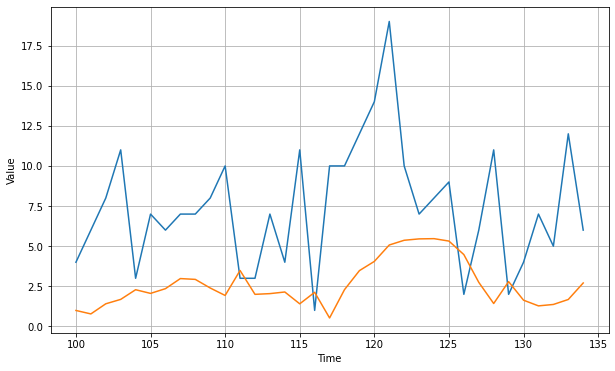

In [21]:
plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()

5.073966

## data Filtering

Used different codes for the pre processing and post processing parts.

In [1]:
import pandas as pd
train_path = 'train_data.csv'
train_dataset = pd.read_csv(train_path)
train_dataset = train_dataset.drop_duplicates(keep = 'first')

def date_to_week(train_dataset):
    for i in range(len(train_dataset)):
        train_dataset["DateID"][i] 
        week_num= pd.Timestamp(train_dataset["DateID"][i]).week
        if week_num <=10:
            train_dataset["DateID"][i] = 52 + week_num -38
        else:
            train_dataset["DateID"][i] = week_num -38
    train_dataset.to_csv("weekly_train_data.csv")

date_to_week(train_dataset)
train_dataset.head()


C:\Users\Manjitha Kularatne\anaconda3\envs\Machine_learning\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Manjitha Kularatne\anaconda3\envs\Machine_learning\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,6,7
1,category_4,836584,8,16
2,category_1,370195,18,6
3,category_2,172582,5,5
4,category_2,1006009,5,5


In [17]:
filtered_items=train_dataset.sort_values(by=["ItemCode","DateID"])
filtered_items.head()

,CategoryCode,ItemCode,DateID,DailySales
2391,category_1,3418,1,8
8755,category_1,3418,1,18
17385,category_1,3418,1,3
2076,category_1,3418,2,12
8593,category_1,3418,2,2


In [3]:
train_dataset.to_csv("weekly_train_data.csv")

In [39]:

grouped_df = filtered_items.groupby(["ItemCode", "CategoryCode" , "DateID"])
grouped_and_summed = grouped_df.sum()
grouped_and_summed = grouped_and_summed.reset_index()
Unique_id =[]
for i in range(len(grouped_and_summed["ItemCode"])):
    Unique_id.append(str(grouped_and_summed["ItemCode"][i])+"_"+str(grouped_and_summed["DateID"][i]))
grouped_and_summed['Unique_ID'] = Unique_id

grouped_and_summed = grouped_and_summed.rename(columns={"DateID":"Week_num"})
grouped_and_summed = grouped_and_summed.rename(columns={"DailySales":"WeeklySales"})
grouped_and_summed.head()



,ItemCode,CategoryCode,Week_num,WeeklySales,Unique_ID
0,3418,category_1,1,29,3418_1
1,3418,category_1,2,42,3418_2
2,3418,category_1,3,41,3418_3
3,3418,category_1,4,41,3418_4
4,3418,category_1,5,44,3418_5


In [33]:
Unique_id =[]
for i in range(len(grouped_and_summed["ItemCode"])):
    Unique_id.append(str(grouped_and_summed["ItemCode"][i])+"_"+str(grouped_and_summed["DateID"][i]))
grouped_and_summed['Unique_ID'] = Unique_id
grouped_and_summed.head()

,ItemCode,CategoryCode,DateID,DailySales,Unique_ID
0,3418,category_1,1,29,3418_1
1,3418,category_1,2,42,3418_2
2,3418,category_1,3,41,3418_3
3,3418,category_1,4,41,3418_4
4,3418,category_1,5,44,3418_5


In [40]:
grouped_and_summed = grouped_and_summed.rename(columns={"DateID":"Week_num"})
grouped_and_summed = grouped_and_summed.rename(columns={"DailySales":"WeeklySales"})
grouped_and_summed.head()

,ItemCode,CategoryCode,Week_num,WeeklySales,Unique_ID
0,3418,category_1,1,29,3418_1
1,3418,category_1,2,42,3418_2
2,3418,category_1,3,41,3418_3
3,3418,category_1,4,41,3418_4
4,3418,category_1,5,44,3418_5


In [41]:
grouped_and_summed.to_csv("weekly_train_data.csv")

In [61]:
train_path = 'validation_data.csv'
valid_dataset = pd.read_csv(train_path)
valid_dataset = train_dataset.drop_duplicates(keep = 'first')


In [69]:
for i in range(valid_dataset.shape[0]):
    week = valid_dataset["Week"][i][-1]
    valid_dataset["Week"][i] = week



C:\Users\Manjitha Kularatne\anaconda3\envs\Machine_learning\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
valid_dataset = valid_dataset.rename(columns={"Week":"Week_num"})
sorted_valid = valid_dataset.sort_values(by=['ItemCode','Week_num'])

sorted_valid.head()
sorted_valid.to_csv("weekly_valid_sort.csv")


NameError: name 'valid_dataset' is not defined

In [83]:
Uni_id =[]
for i in range(len(grouped_and_summed_valid["ItemCode"])):
    Uni_id.append(str(grouped_and_summed_valid["ItemCode"][i])+"_"+str(grouped_and_summed_valid["Week_num"][i]))
grouped_and_summed_valid['Uniqe_ID'] = Uni_id
grouped_and_summed_valid.head()


,CategoryCode,ItemCode,Week_num,WeeklySales,Unique_ID,Uniqe_ID
182,category_1,3418,1,25,1044502_1,1044502_1
141,category_1,3418,2,69,1105009_1,1105009_1
190,category_1,3418,3,120,913561_4,913561_4
369,category_1,3418,4,69,1048975_4,1048975_4
304,category_1,3427,1,7,17287_2,17287_2


In [79]:
grouped_and_summed_valid.to_csv("weekly_valid_data.csv")

In [84]:
print(grouped_and_summed_valid["ItemCode"][0])

1044502


In [92]:
train_path = 'weekly_valid_sort.csv'
valid_dataset = pd.read_csv(train_path)
valid_dataset_sort = valid_dataset.drop_duplicates(keep = 'first')

In [94]:
valid_dataset_sort.head()

,Unnamed: 0,CategoryCode,ItemCode,Week_num,WeeklySales
0,182,category_1,3418,1,25
1,141,category_1,3418,2,69
2,190,category_1,3418,3,120
3,369,category_1,3418,4,69
4,304,category_1,3427,1,7


In [96]:
Uni_id =[]
for i in range(len(valid_dataset_sort["ItemCode"])):
    Uni_id.append(str(valid_dataset_sort["ItemCode"][i])+"_"+str(valid_dataset_sort["Week_num"][i]))
valid_dataset_sort['Uniqe_ID'] = Uni_id
valid_dataset_sort.head()
# print(valid_dataset_sort['ItemCode'][0])

,Unnamed: 0,CategoryCode,ItemCode,Week_num,WeeklySales,Uniqe_ID
0,182,category_1,3418,1,25,3418_1
1,141,category_1,3418,2,69,3418_2
2,190,category_1,3418,3,120,3418_3
3,369,category_1,3418,4,69,3418_4
4,304,category_1,3427,1,7,3427_1


In [97]:
valid_dataset_sort.to_csv("weekly_valid_data_sorted.csv")

In [2]:
import pandas as pd

test_path = 'test_data.csv'
test_dataset = pd.read_csv(test_path)
test_dataset = test_dataset.drop_duplicates(keep = 'first')
test_dataset.head()


,CategoryCode,ItemCode,Week,PredictedSales
0,category_1,43738,w4,NaN
1,category_2,1006090,w1,NaN
2,category_2,1076929,w4,NaN
3,category_1,1081321,w3,NaN
4,category_2,216151,w4,NaN


In [3]:
test_dataset_sort= test_dataset.sort_values(by = ["ItemCode","Week"])

test_dataset_sort.head()


,CategoryCode,ItemCode,Week,PredictedSales
343,category_2,9925,w1,NaN
268,category_2,9925,w2,NaN
50,category_2,9925,w3,NaN
348,category_2,9925,w4,NaN
360,category_3,16936,w1,NaN


In [4]:
def edit_dataset(test_dataset,itemCode,predict_list):
    try:
        for i in range(len(predict_list)):
            week = "w" + str(i+1)
            x =set(test_dataset[test_dataset['ItemCode']==itemCode].index.values)
            y =set(test_dataset[test_dataset['Week']==week].index.values)
            index = list(x.intersection(y))[0]
            test_dataset.at[index, 'PredictedSales'] = predict_list[i]
    except:
        pass
    
edit_dataset(test_dataset_sort,9925,[1,2,3,4])
test_dataset_sort.head()

,CategoryCode,ItemCode,Week,PredictedSales
343,category_2,9925,w1,1.0
268,category_2,9925,w2,2.0
50,category_2,9925,w3,3.0
348,category_2,9925,w4,4.0
360,category_3,16936,w1,NaN


In [45]:
import pandas as pd

test_path = 'test_data.csv'
test_dataset = pd.read_csv(test_path)
test_dataset_sort = test_dataset.drop_duplicates(keep = 'first')
data_list = test_dataset_sort["ItemCode"].to_list()
data_list = list(set(data_list))
print(data_list)



[687616, 42496, 87046, 87559, 1006090, 1071115, 39436, 370195, 1006099, 169504, 36898, 16936, 145978, 1067074, 216151, 1092184, 43630, 1067119, 38518, 1067128, 35449, 1105018, 1044610, 1105027, 37510, 23200, 1003183, 1063600, 1049776, 1003192, 1076929, 9925, 35530, 839374, 1056463, 1103056, 1090258, 1044691, 267478, 43738, 57058, 1070818, 1081060, 1081069, 132334, 262384, 1101553, 1081078, 1101562, 65788, 119554, 1101571, 1054978, 858886, 1060630, 111382, 903976, 1024810, 213802, 1085749, 837943, 838456, 872260, 111436, 1021264, 1068883, 1032532, 906595, 174436, 41830, 117610, 1032559, 1082743, 1032568, 1077118, 893824, 88450, 1047967, 371104, 123307, 130993, 145330, 42424, 1075651, 1101769, 753613, 86992, 1061341, 731104, 37861, 1090024, 1081321, 999403, 225259, 32245, 1081339, 815101]


In [107]:
prophet_path = 'SARIMA_new.csv'
prophet_dataset = pd.read_csv(prophet_path)
prophet_dataset = prophet_dataset.drop_duplicates(keep = 'first')
prophet_dataset = prophet_dataset.T
prophet_dataset.to_csv("SARIMA.csv")
prophet_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
ItemCode,9925.000000,16936.000000,23200.000000,32245.000000,35449.000000,35530.000000,36898.000000,37510.000000,37861.000000,38518.000000,...,1.090024e+06,1.090258e+06,1.092184e+06,1.101553e+06,1.101562e+06,1.101571e+06,1.101769e+06,1.103056e+06,1.105018e+06,1.105027e+06
w1,20.491297,54.926803,190.070900,40.983672,32.203098,21.773969,78.878584,13.445196,199.884761,25.525929,...,5.152934e+01,4.698039e+01,2.476005e+01,1.234953e+01,3.136189e+00,1.150897e+01,2.528205e+01,1.849170e+01,1.413981e+01,1.543365e+01
w2,22.918093,57.229188,183.355271,43.611528,34.991106,32.299668,68.339688,11.510964,241.170782,23.656718,...,4.931175e+01,5.183363e+01,2.617941e+01,2.051021e+01,8.830261e+00,7.348559e+00,2.686274e+01,1.808376e+01,1.072057e+01,1.593057e+01
w3,23.254490,54.420181,220.371969,43.767781,37.330459,22.329564,72.932797,13.793931,207.770162,26.108287,...,5.121298e+01,5.135274e+01,2.628047e+01,1.135826e+01,1.261390e+00,9.536264e+00,2.690582e+01,1.871679e+01,1.407377e+01,1.624480e+01
w4,24.049950,57.131326,209.786430,43.765199,39.079555,33.080620,66.674325,11.982785,262.283041,24.127061,...,5.096428e+01,5.484167e+01,2.685257e+01,1.599484e+01,7.258948e+00,4.602182e+00,2.856575e+01,1.809011e+01,1.040258e+01,1.616170e+01


In [136]:
prophet_path = 'lstm_test_results.csv'
prophet_dataset = pd.read_csv(prophet_path)
prophet_dataset = prophet_dataset.drop_duplicates(keep = 'first')
prophet_dataset= prophet_dataset.sort_values(by = ["ItemCode","Week"])
# prophet_dataset = prophet_dataset.T
# prophet_dataset.to_csv("lstm.csv")
prophet_dataset.head()
prophet_dataset.to_csv("lstm_predicted.csv")

In [137]:
prophet_dataset.head()

,CategoryCode,ItemCode,Week,PredictedSales
156,category_2,9925,w1,9.369832
157,category_2,9925,w2,10.188362
158,category_2,9925,w3,16.576864
159,category_2,9925,w4,2.826452
372,category_3,16936,w1,108.814026


In [53]:
prophet_list = prophet_dataset.loc[0].to_list()[1:]
prophet_list = [ int(x) for x in prophet_list ]
print(prophet_list)

[9925, 16936, 23200, 32245, 35449, 35530, 36898, 37510, 37861, 38518, 39436, 41830, 42424, 42496, 43630, 43738, 57058, 65788, 86992, 87046, 87559, 88450, 111382, 111436, 117610, 119554, 123307, 130993, 132334, 145330, 145978, 169504, 174436, 213802, 216151, 225259, 262384, 267478, 370195, 371104, 687616, 731104, 753613, 815101, 837943, 838456, 839374, 858886, 872260, 893824, 903976, 906595, 999403, 1003183, 1003192, 1006090, 1006099, 1021264, 1024810, 1032532, 1032559, 1032568, 1044610, 1044691, 1047967, 1049776, 1054978, 1056463, 1060630, 1061341, 1063600, 1067074, 1067119, 1067128, 1068883, 1070818, 1071115, 1075651, 1076929, 1077118, 1081060, 1081069, 1081078, 1081321, 1081339, 1082743, 1085749, 1090024, 1090258, 1092184, 1101553, 1101562, 1101571, 1101769, 1103056, 1105018, 1105027]


In [29]:
for i in range(len(data_list)):
    for j in range(97):
        if data_list[i] == int(prophet_dataset[str(i)][0]):
            
print(int(prophet_dataset["0"][0]))

9925


In [138]:
import pandas as pd
import numpy as np

test_path = 'test_data.csv'
test_dataset = pd.read_csv(test_path)
test_dataset= test_dataset.sort_values(by = ["ItemCode","Week"])
test_dataset = test_dataset.drop_duplicates(keep = 'first')
test_dataset["MAPE"]=np.nan
test_dataset.head()
# test_dataset.to_csv("test_lstm_predicted.csv")

,CategoryCode,ItemCode,Week,PredictedSales,MAPE
343,category_2,9925,w1,NaN,NaN
268,category_2,9925,w2,NaN,NaN
50,category_2,9925,w3,NaN,NaN
348,category_2,9925,w4,NaN,NaN
360,category_3,16936,w1,NaN,NaN


In [114]:

for  j in range(97):
    itemcode = int(prophet_dataset[str(j)][0])
    index=test_dataset[test_dataset['ItemCode']==itemcode].index.values
    for i in index:
        week_num =str(test_dataset['Week'][i])[-1]
        test_dataset['PredictedSales'][i] = prophet_dataset[str(j)][int(week_num)]
        test_dataset['MAPE'][i] = prophet_dataset[str(j)][5]
test_dataset.head()

C:\Users\Manjitha Kularatne\anaconda3\envs\Machine_learning\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Manjitha Kularatne\anaconda3\envs\Machine_learning\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Manjitha Kularatne\anaconda3\envs\Machine_learning\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

,CategoryCode,ItemCode,Week,PredictedSales,MAPE
343,category_2,9925,w1,20.491297,74.990958
268,category_2,9925,w2,22.918093,74.990958
50,category_2,9925,w3,23.254490,74.990958
348,category_2,9925,w4,24.049950,74.990958
360,category_3,16936,w1,54.926803,145.053564


In [115]:
test_dataset= test_dataset.sort_values(by = ["ItemCode","Week"])
test_dataset.head()


,CategoryCode,ItemCode,Week,PredictedSales,MAPE
343,category_2,9925,w1,20.491297,74.990958
268,category_2,9925,w2,22.918093,74.990958
50,category_2,9925,w3,23.254490,74.990958
348,category_2,9925,w4,24.049950,74.990958
360,category_3,16936,w1,54.926803,145.053564


In [116]:
test_dataset.to_csv("SARIMA_predicted.csv")


In [129]:
dataset= pd.merge(prophet_dataset, test_dataset, how ='outer', on =[ 'Week'])
dataset.head()

,CategoryCode_x,ItemCode_x,Week,PredictedSales_x,CategoryCode_y,ItemCode_y,PredictedSales_y,MAPE
0,category_2,9925,w1,9.369832,category_2,9925,NaN,NaN
1,category_2,9925,w1,9.369832,category_3,16936,NaN,NaN
2,category_2,9925,w1,9.369832,category_4,23200,NaN,NaN
3,category_2,9925,w1,9.369832,category_2,32245,NaN,NaN
4,category_2,9925,w1,9.369832,category_1,35449,NaN,NaN
